In [ ]:
import numpy as np
import random
import matplotlib as plt
from scipy.special import digamma, gamma

np.random.seed(10)

# k-NN entropy estimator for the point cloud X in d-dimensional torus
def kNN_entropy_est(X, k=1):
    d, m = X.shape
    dists = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            diff = np.abs(X[:, i] - X[:, j])
            torus_dist = np.minimum(diff, 2 * np.pi - diff) 
            dists[i, j] = np.sqrt(np.sum(torus_dist**2))

    kdist = np.sort(dists, axis=1)[:, k]  # k-th nearest neighbor distance
    H = -digamma(m) + digamma(k) - (d / 2) * np.log(np.pi) + np.log(gamma(1 + d / 2)) - (d / m) * np.sum(np.log(kdist))
    return H

# Particle Gradient Descent (PGD) 
def PGD(X_init, objective_func, grad_func, tau, n_iter, step_size=0.08, annealed=True):
    d, m = X_init.shape
    X = np.zeros((d, m, n_iter))
    X[:, :, 0] = X_init
    G = np.zeros(n_iter - 1)  
    H = np.zeros(n_iter - 1)  

    tau_t = tau

    for t in range(n_iter - 1):
        if annealed:    
            tau_t = tau * (t + 1) ** -1
        else:
            tau_t = tau
        G[t] = np.mean([objective_func(X[:, i, t]) for i in range(m)])
        H[t] = kNN_entropy_est(X[:, :, t])
        G[t] = G[t] + tau_t * H[t]

        grad = np.zeros((d, m))
        for i in range(m):
            grad[:, i] = grad_func(X[:, i, t])
            noise = np.sqrt(2 * step_size * tau_t) * np.random.randn(d, m)
            X[:, :, t + 1] = X[:, :, t] - step_size * grad + noise

    return X, G


## Noise Particle Gradient Descent

In [6]:
# k-NN entropy estimator for the point cloud X in d-dimensional torus
def kNN_entropy_est(X, k=1):
    d, m = X.shape
    dists = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            diff = np.abs(X[:, i] - X[:, j])
            torus_dist = np.minimum(diff, 2 * np.pi - diff) 
            dists[i, j] = np.sqrt(np.sum(torus_dist**2))

    kdist = np.sort(dists, axis=1)[:, k]  # k-th nearest neighbor distance
    H = -digamma(m) + digamma(k) - (d / 2) * np.log(np.pi) + np.log(gamma(1 + d / 2)) - (d / m) * np.sum(np.log(kdist))
    return H

# Particle Gradient Descent (PGD) 
def PGD(X_init, objective_func, grad_func, tau, n_iter, step_size=0.08, annealed=True):
    d, m = X_init.shape
    X = np.zeros((d, m, n_iter))
    X[:, :, 0] = X_init
    G = np.zeros(n_iter - 1)  
    H = np.zeros(n_iter - 1)  

    tau_t = tau

    for t in range(n_iter - 1):
        if annealed:
            tau_t = tau * (t + 1) ** -1
        else:
            tau_t = tau
        G[t] = np.mean([objective_func(X[:, i, t]) for i in range(m)])
        H[t] = kNN_entropy_est(X[:, :, t])
        G[t] = G[t] + tau_t * H[t]

        grad = np.zeros((d, m))
        for i in range(m):
            grad[:, i] = grad_func(X[:, i, t])
            noise = np.sqrt(2 * step_size * tau_t) * np.random.randn(d, m)
            X[:, :, t + 1] = X[:, :, t] - step_size * grad + noise

    return X, G


## Noise Particle Gradient Descent with Landscape Modification

In [7]:
def grad_LM(G_t, grad, iter, c, alpha_init, decay_factor, f, epsilon):
    alpha = alpha_init * (decay_factor ** iter)
    mod_factor = alpha * f(max(0, (G_t - c))) + epsilon
    return grad / mod_factor

# Particle Gradient Descent with Landscape Modification (PGD_LM)
def PGD_LM(X_init, objective_func, grad_func, tau, n_iter, alpha_init=1.0, decay_factor=1.0, f=lambda x: x**2, epsilon=1.0, 
           c_func="adaptive avg", annealed=True, step_size=0.08):
    d, m = X_init.shape
    X = np.zeros((d, m, n_iter))
    X[:, :, 0] = X_init
    G = np.zeros(n_iter - 1) 
    H = np.zeros(n_iter - 1) 
    C = np.full((m, n_iter - 1), 1e6) 
    c = np.full(m, 1e6) 

    tau_t = tau

    for t in range(n_iter - 1):
        if annealed:
            tau_t = tau * (t + 1) ** -1
        else:
            tau_t = tau

        G[t] = np.mean([objective_func(X[:, i, t]) for i in range(m)])
        H[t] = kNN_entropy_est(X[:, :, t])
        G[t] = G[t] + tau_t * H[t]

        grad = np.zeros((d, m))
        for i in range(m):
            if c_func == "adaptive avg":
                c[i] = min(c[i], np.mean([objective_func(X[:, j, t]) for j in range(m)]))
            elif c_func == "curr avg":
                c[i] = np.mean([objective_func(X[:, j, t]) for j in range(m)])
            elif c_func == "running min":
                c[i] = min(c[i], objective_func(X[:, i, t]))
            C[i, t] = c[i]  # Store updated c for each particle
        
        for i in range(m):
            grad[:, i] = grad_func(X[:, i, t])
            grad[:, i] = grad_LM(G[t], grad[:, i], t, c[i], alpha_init, decay_factor, f, epsilon)  # Apply LM
    
        noise = np.sqrt(2 * step_size * tau_t) * np.random.randn(d, m)
        X[:, :, t + 1] = X[:, :, t] - step_size * grad + noise

    return X, G, C

## Benchmark Algorithms: SGD, AdaGrad

In [8]:
def SGD(X_init, func, grad_func, step_size=0.08, n_iter=100, noise_scale=0.1):
    X = np.zeros((n_iter+1, len(X_init)))
    G = np.zeros(n_iter+1)
    X[0] = np.array(X_init, dtype=np.float64)
    G[0] = func(X[0])
    
    for i in range(n_iter):
        grad = grad_func(X[i])
        noise = np.random.normal(0, noise_scale, size=grad.shape)
        X[i+1] = X[i] - step_size * (grad + noise)
        G[i+1] = func(X[i+1])
    
    return X, G



def Adagrad(X_init, func, grad_func, step_size=0.08, n_iter=100, epsilon=1e-8):
    X = np.zeros((n_iter+1, len(X_init)))
    G = np.zeros(n_iter+1)
    X[0] = X_init
    G[0] = func(X_init)

    # Accumulate squared gradients
    grad_accum = np.zeros_like(X_init)

    for i in range(n_iter):
        grad = grad_func(X[i])
        grad_accum += grad**2
        lr_adjusted = step_size / (np.sqrt(grad_accum) + epsilon)
        X[i+1] = X[i] - lr_adjusted * grad
        G[i+1] = func(X[i+1])

    return X, G



## Experiment 1: Ackley Function

$$
f(\mathbf{x})=-a \exp \left(-b \sqrt{\frac{1}{d} \sum_{i=1}^d x_i^2}\right)-\exp \left(\frac{1}{d} \sum_{i=1}^d \cos \left(c x_i\right)\right)+a+\exp (1)
$$

In [19]:
# Function and gradient definition
def ackley(x, a=20, b=0.2, c=2*np.pi):
    x = np.asarray(x, dtype=float)
    d = len(x)
    sum_sq_term = -a * np.exp(-b * np.sqrt(np.sum(x**2) / d))
    cos_term = -np.exp(np.mean(np.cos(c * x)))
    return sum_sq_term + cos_term + a + np.e


def grad_ackley(x, a=20, b=0.2, c=2*np.pi):
    x = np.asarray(x, dtype=float)
    d = len(x)
    sum_sq = np.sum(x**2)

    if sum_sq == 0:
        term1 = np.zeros_like(x)
    else:
        term1 = (a * b / np.sqrt(d)) * (x / np.sqrt(sum_sq)) * np.exp(-b * np.sqrt(sum_sq / d))
    term2 = (c / d) * np.sin(c * x) * np.exp(np.mean(np.cos(c * x)))

    return term1 + term2


In [20]:
# Parameters
d = 2
m = 10
n_iter = 1000
tau = 1
X_init = np.random.uniform(-20, 20, (d, m))  
alpha_init = 10.0
decay_factor = 0.99
f_mod = lambda x: x**2
epsilon = 1.0

In [24]:
# Run Experiment
X_pgd, G_pgd = PGD(X_init, ackley, grad_ackley, tau, n_iter,annealed=False)
# c - adaptive average of objective values
X_pgdlm_adaptive_avg, G_pgdlm_adaptive_avg, C_pgdlm_adaptive_avg = PGD_LM(X_init, ackley, grad_ackley, tau, n_iter,
                                                 alpha_init=alpha_init, decay_factor=decay_factor, 
                                                 f=f_mod, epsilon=epsilon, annealed=False, c_func = "adaptive avg")

# c - the average of objective values from last iteration
X_pgdlm_avg, G_pgdlm_avg, C_pgdlm_avg = PGD_LM(X_init, ackley, grad_ackley, tau, n_iter,
                                                 alpha_init=alpha_init, decay_factor=decay_factor, 
                                                 f=f_mod, epsilon=epsilon, annealed=False, c_func = "curr avg")

# c - the running minimal objective value of the individual particle
X_pgdlm_running_min, G_pgdlm_running_min, C_pgdlm_running_min = PGD_LM(X_init, ackley, grad_ackley, tau, n_iter,
                                                 alpha_init=alpha_init, decay_factor=decay_factor, 
                                                 f=f_mod, epsilon=epsilon, annealed=False, c_func = "running min")

# SGD
X_sgd, G_sgd = SGD(X_init[:,0], ackley, grad_ackley, 0.08, n_iter)


# Adagrad
X_adagrad, G_adagrad = Adagrad(X_init[:,0], ackley, grad_ackley, 0.08, n_iter)

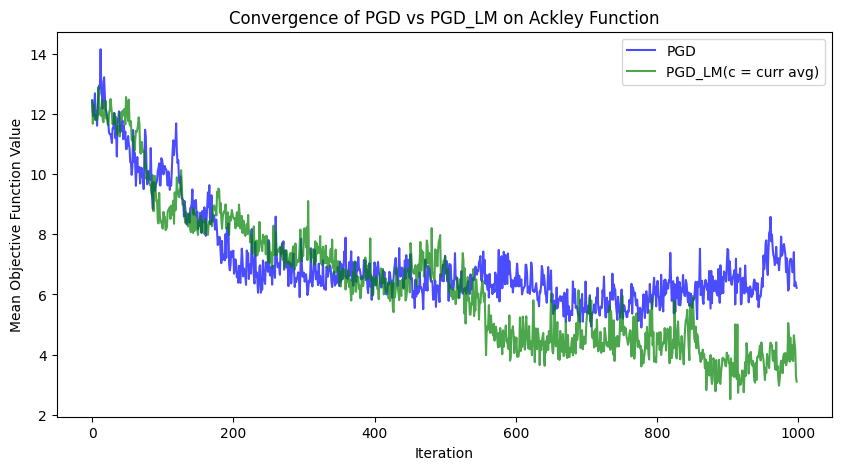

In [25]:
# Plots
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(G_pgd, 'b-', label="PGD", alpha=0.7)
plt.plot(G_pgdlm_avg, 'g-', label="PGD_LM(c = curr avg)", alpha=0.7)

plt.xlabel("Iteration")
plt.ylabel("Mean Objective Function Value")
plt.title("Convergence of PGD vs PGD_LM on Ackley Function")
plt.legend()
plt.show()

### Animation of optimization process

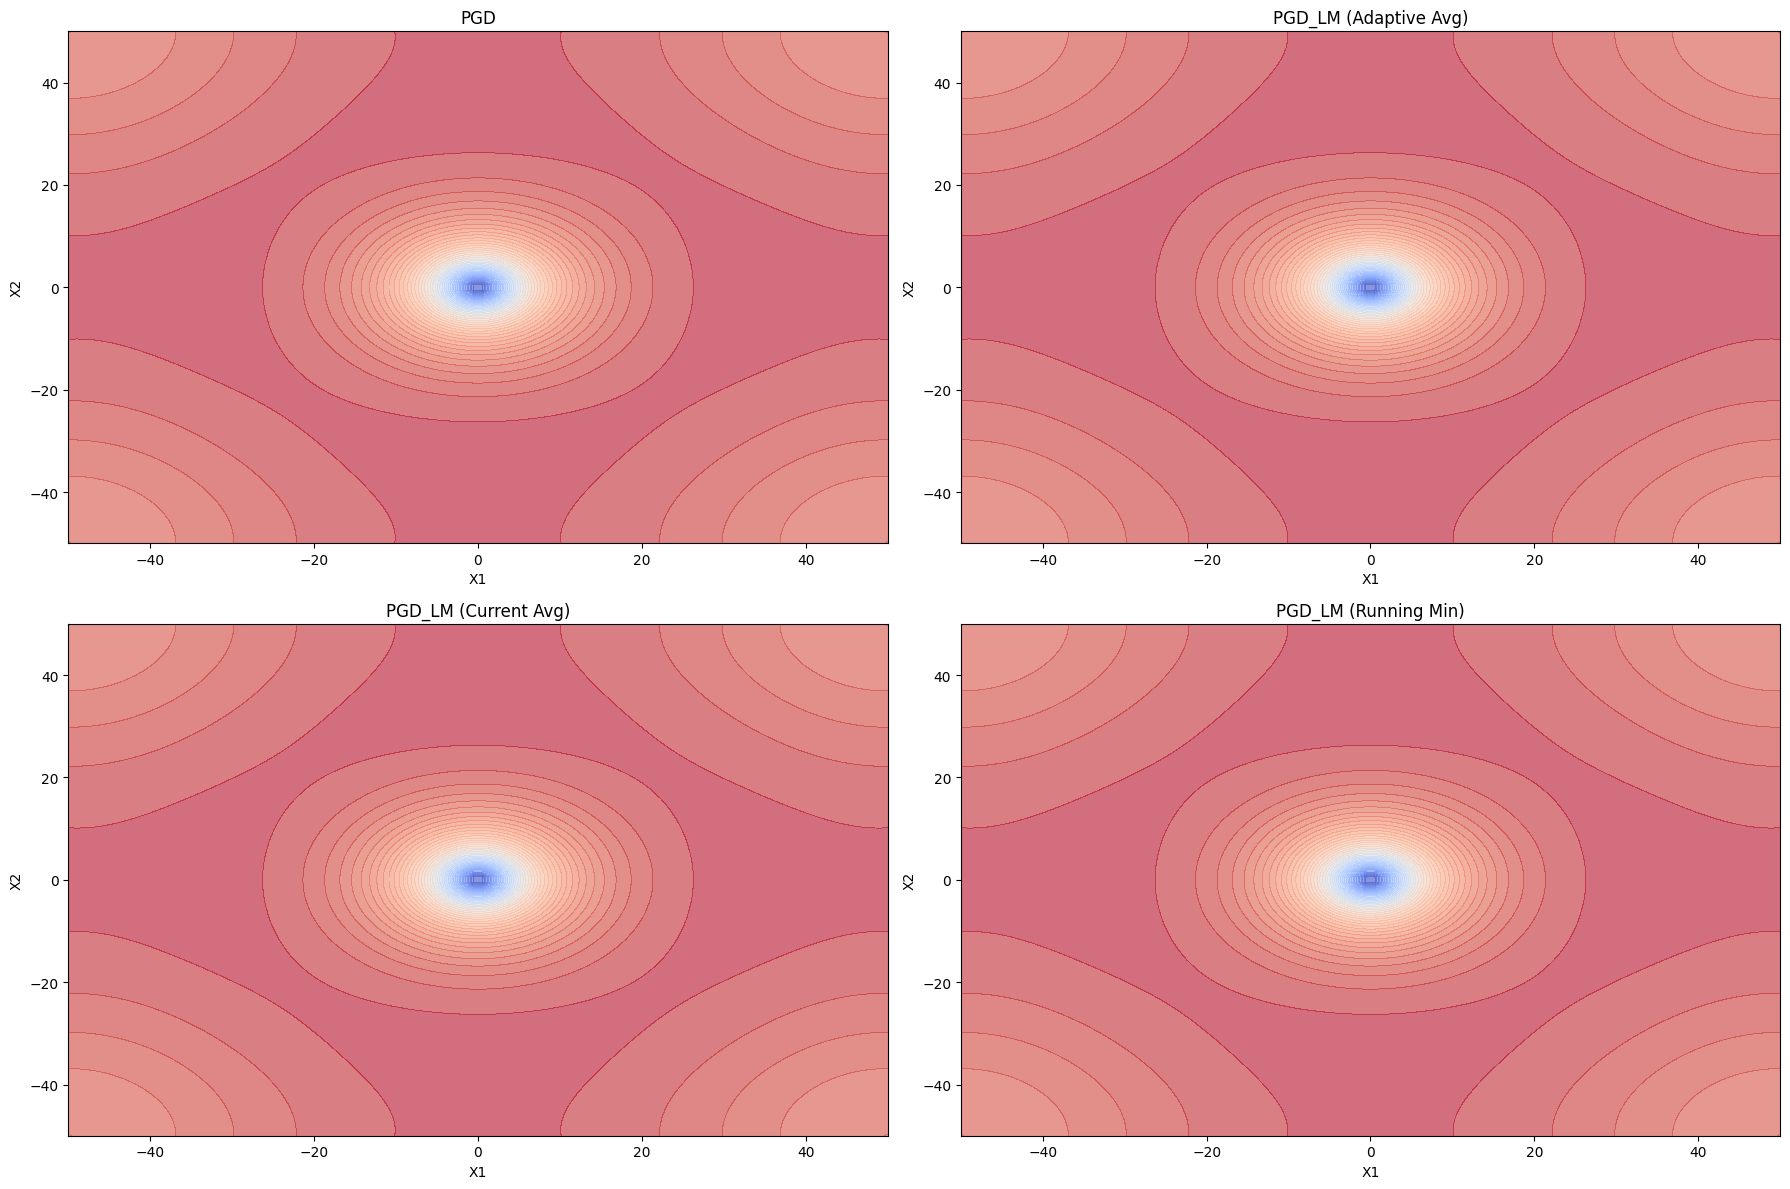

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

x_range = np.linspace(-50, 50, 100)
y_range = np.linspace(-50, 50, 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_grid = np.array([[ackley(np.array([x, y])) for x, y in zip(X_row, Y_row)] for X_row, Y_row in zip(X_grid, Y_grid)])



trajectory_data = [
    (X_pgd, "PGD"),
    (X_pgdlm_adaptive_avg, "PGD_LM (Adaptive Avg)"),
    (X_pgdlm_avg, "PGD_LM (Current Avg)"),
    (X_pgdlm_running_min, "PGD_LM (Running Min)")
]

m = X_pgd.shape[1]  # number of trajectories
T = X_pgd.shape[2]  

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()  

lines_all = []
start_scatter_all = []
current_scatter_all = []

# --- Draw the contour background for each subplot and initialize lines ---
for ax, (X_traj, title) in zip(axes, trajectory_data):
    # Draw the contour for the Ackley function
    contour = ax.contourf(
        X_grid, Y_grid, Z_grid, 
        levels=50, 
        cmap='coolwarm', 
        alpha=0.6
    )
    ax.set_title(title)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")

    subplot_lines = []
    subplot_start_scatter = []
    subplot_current_scatter = []

    for i in range(m):
        line_obj, = ax.plot([], [], 'b-', alpha=0.6)
        start_scat = ax.scatter([], [], color='blue', marker='x')
        current_scat = ax.scatter([], [], color='darkblue', marker='o')

        subplot_lines.append(line_obj)
        subplot_start_scatter.append(start_scat)
        subplot_current_scatter.append(current_scat)

    lines_all.append(subplot_lines)
    start_scatter_all.append(subplot_start_scatter)
    current_scatter_all.append(subplot_current_scatter)

# --- Animation functions ---

def init():
    for subplot_lines, subplot_starts, subplot_currents in zip(
        lines_all, start_scatter_all, current_scatter_all
    ):
        for line_obj, start_scat, current_scat in zip(
            subplot_lines, subplot_starts, subplot_currents
        ):
            line_obj.set_data([], [])
            start_scat.set_offsets(np.zeros((0, 2)))
            current_scat.set_offsets(np.zeros((0, 2)))
    return []

def update(frame):
    # We iterate through each subplot's data
    for subplot_idx, (X_traj, _) in enumerate(trajectory_data):
        lines = lines_all[subplot_idx]
        starts = start_scatter_all[subplot_idx]
        currents = current_scatter_all[subplot_idx]

        for i in range(m):
            x_data = X_traj[0, i, :frame+1]
            y_data = X_traj[1, i, :frame+1]

            lines[i].set_data(x_data, y_data)
            starts[i].set_offsets([X_traj[0, i, 0], X_traj[1, i, 0]])
            currents[i].set_offsets([X_traj[0, i, frame], X_traj[1, i, frame]])

    return []


ani = animation.FuncAnimation(
    fig,         
    update,     
    frames=T,   
    init_func=init,
    blit=False, 
    interval=200 
)

plt.tight_layout()
plt.show()


In [ ]:
ffmpeg_writer = animation.FFMpegWriter(fps=5, extra_args=['-vcodec', 'libx264'])
ani.save("Plots/trajectories_Ackley.mp4", writer='ffmpeg', fps=5)

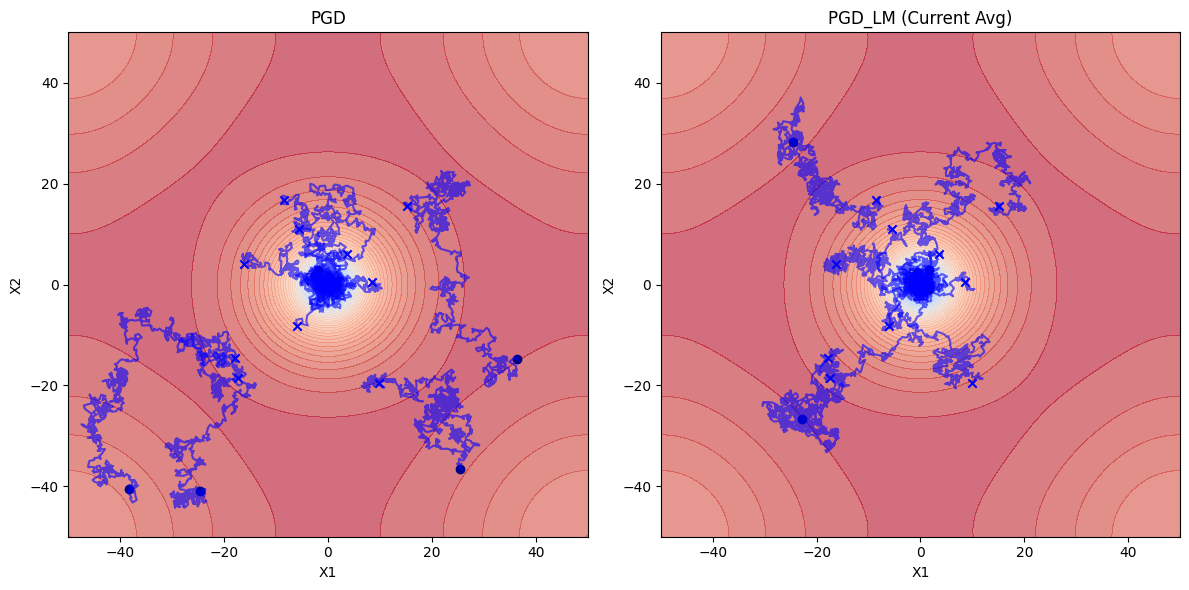

In [26]:
x_range = np.linspace(-50, 50, 100)
y_range = np.linspace(-50, 50, 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_grid = np.array([[ackley(np.array([x, y])) for x, y in zip(X_row, Y_row)] for X_row, Y_row in zip(X_grid, Y_grid)])


trajectory_data = [
    (X_pgd, "PGD"),
    (X_pgdlm_avg, "PGD_LM (Current Avg)")
]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, (X_traj, title) in zip(axes.flatten(), trajectory_data):
    ax.contourf(X_grid, Y_grid, Z_grid, levels=50, cmap='coolwarm', alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")

    # Plot trajectories
    for i in range(m):
        ax.plot(X_traj[0, i, :], X_traj[1, i, :], 'b-', alpha=0.6)
        ax.scatter(X_traj[0, i, 0], X_traj[1, i, 0], color='blue', marker='x')  # Start position
        ax.scatter(X_traj[0, i, -1], X_traj[1, i, -1], color='darkblue', marker='o')  # Final position

plt.tight_layout()
plt.show()

## Experiment 2: Bohachevsky Function

In [16]:
def bohachevsky(x):
    return x[0]**2 + 2 * x[1]**2 - 0.3 * np.cos(3 * np.pi * x[0]) - 0.4 * np.cos(4 * np.pi * x[1]) + 0.7

# Gradient of the Bohachevsky function
def grad_bohachevsky(x):
    grad_x1 = 2 * x[0] + 0.9 * np.pi * np.sin(3 * np.pi * x[0])
    grad_x2 = 4 * x[1] + 1.6 * np.pi * np.sin(4 * np.pi * x[1])
    return np.array([grad_x1, grad_x2])

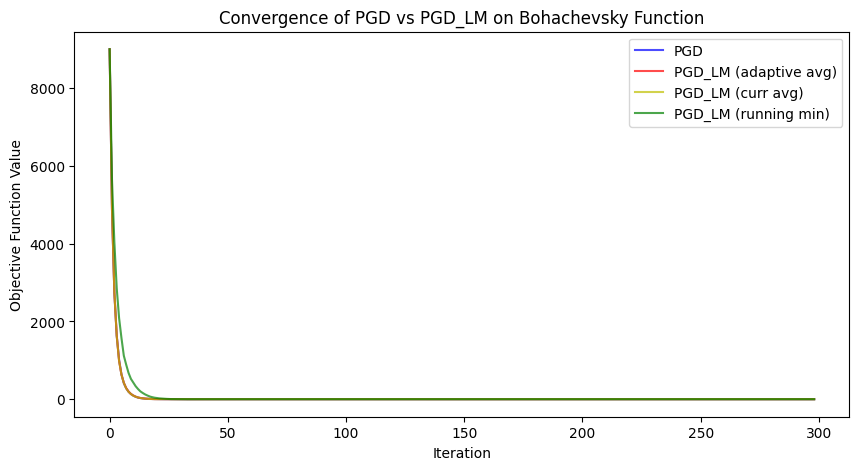

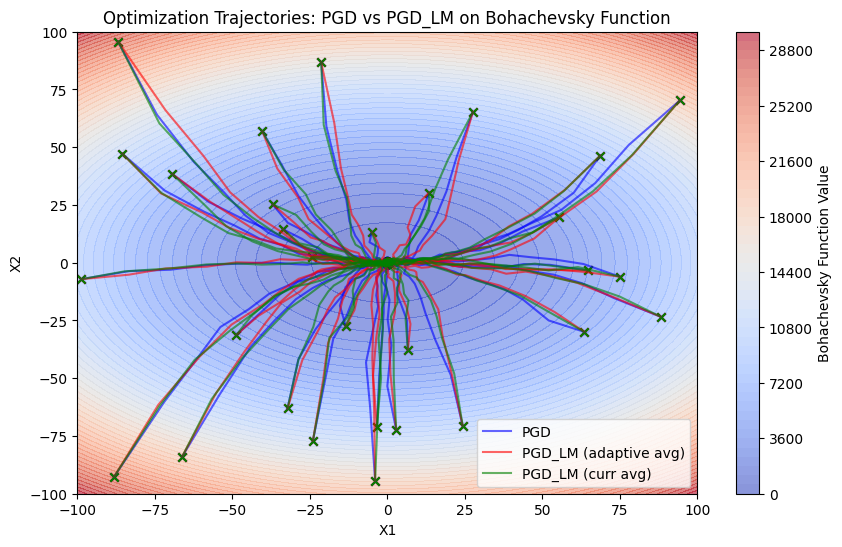

In [27]:
# Experiment parameters
d = 2  
m = 30 
n_iter = 300 
tau = 15.0  
X_init = np.random.uniform(-100, 100, (d, m))  # Randomly initialize particles

alpha_init = 1.0
decay_factor = 0.99
f_mod = lambda x: x**2
epsilon = 1.0

# Run Experiment
X_pgd, G_pgd = PGD(X_init, bohachevsky, grad_bohachevsky, tau, n_iter)
X_pgdlm_adaptive_avg, G_pgdlm_adaptive_avg, _ = PGD_LM(X_init, bohachevsky, grad_bohachevsky, tau, n_iter,
                             alpha_init=alpha_init, decay_factor=decay_factor, 
                             f=f_mod, epsilon=epsilon, c_func = "adaptive avg")
X_pgdlm_avg, G_pgdlm_avg, _ = PGD_LM(X_init, bohachevsky, grad_bohachevsky, tau, n_iter,
                             alpha_init=alpha_init, decay_factor=decay_factor, 
                             f=f_mod, epsilon=epsilon,c_func = "curr avg")
X_pgdlm_running_min, G_pgdlm_running_min, _ = PGD_LM(X_init, bohachevsky, grad_bohachevsky, tau, n_iter,
                             alpha_init=alpha_init, decay_factor=decay_factor, 
                             f=f_mod, epsilon=epsilon,c_func = "running min")


# Convergence Plot
plt.figure(figsize=(10, 5))
plt.plot(G_pgd, 'b-', label="PGD", alpha=0.7)
plt.plot(G_pgdlm_adaptive_avg, 'r-', label="PGD_LM (adaptive avg)", alpha=0.7)
plt.plot(G_pgdlm_avg, 'y-', label="PGD_LM (curr avg)", alpha=0.7)
plt.plot(G_pgdlm_running_min, 'g-', label="PGD_LM (running min)", alpha=0.7)
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence of PGD vs PGD_LM on Bohachevsky Function")
plt.legend()
plt.show()

# Create a contour plot of the 2D Bohachevsky function
x_range = np.linspace(-100, 100, 100)
y_range = np.linspace(-100, 100, 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_grid = np.array([[bohachevsky(np.array([x, y])) for x, y in zip(X_row, Y_row)] for X_row, Y_row in zip(X_grid, Y_grid)])

plt.figure(figsize=(10, 6))
plt.contourf(X_grid, Y_grid, Z_grid, levels=50, cmap='coolwarm', alpha=0.6)
plt.colorbar(label="Bohachevsky Function Value")

# Plot trajectories of PGD
for i in range(m):
    plt.plot(X_pgd[0, i, :], X_pgd[1, i, :], 'b-', alpha=0.6, label="PGD" if i == 0 else "")
    plt.scatter(X_pgd[0, i, 0], X_pgd[1, i, 0], color='blue', marker='x')  # Start position
    plt.scatter(X_pgd[0, i, -1], X_pgd[1, i, -1], color='darkblue', marker='o')  # Final position

# Plot trajectories of PGD_LM (adaptive avg)
for i in range(m):
    plt.plot(X_pgdlm_adaptive_avg[0, i, :], X_pgdlm_adaptive_avg[1, i, :], 'r-', alpha=0.6, label="PGD_LM (adaptive avg)" if i == 0 else "")
    plt.scatter(X_pgdlm_adaptive_avg[0, i, 0], X_pgdlm_adaptive_avg[1, i, 0], color='red', marker='x')  # Start position
    plt.scatter(X_pgdlm_adaptive_avg[0, i, -1], X_pgdlm_adaptive_avg[1, i, -1], color='darkred', marker='o')  # Final position

# Plot trajectories of PGD_LM (curr avg)
for i in range(m):
    plt.plot(X_pgdlm_avg[0, i, :], X_pgdlm_avg[1, i, :], 'g-', alpha=0.6, label="PGD_LM (curr avg)" if i == 0 else "")
    plt.scatter(X_pgdlm_avg[0, i, 0], X_pgdlm_avg[1, i, 0], color='green', marker='x')  # Start position
    plt.scatter(X_pgdlm_avg[0, i, -1], X_pgdlm_avg[1, i, -1], color='darkgreen', marker='o')  # Final position

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Optimization Trajectories: PGD vs PGD_LM on Bohachevsky Function")
plt.legend()
plt.show()

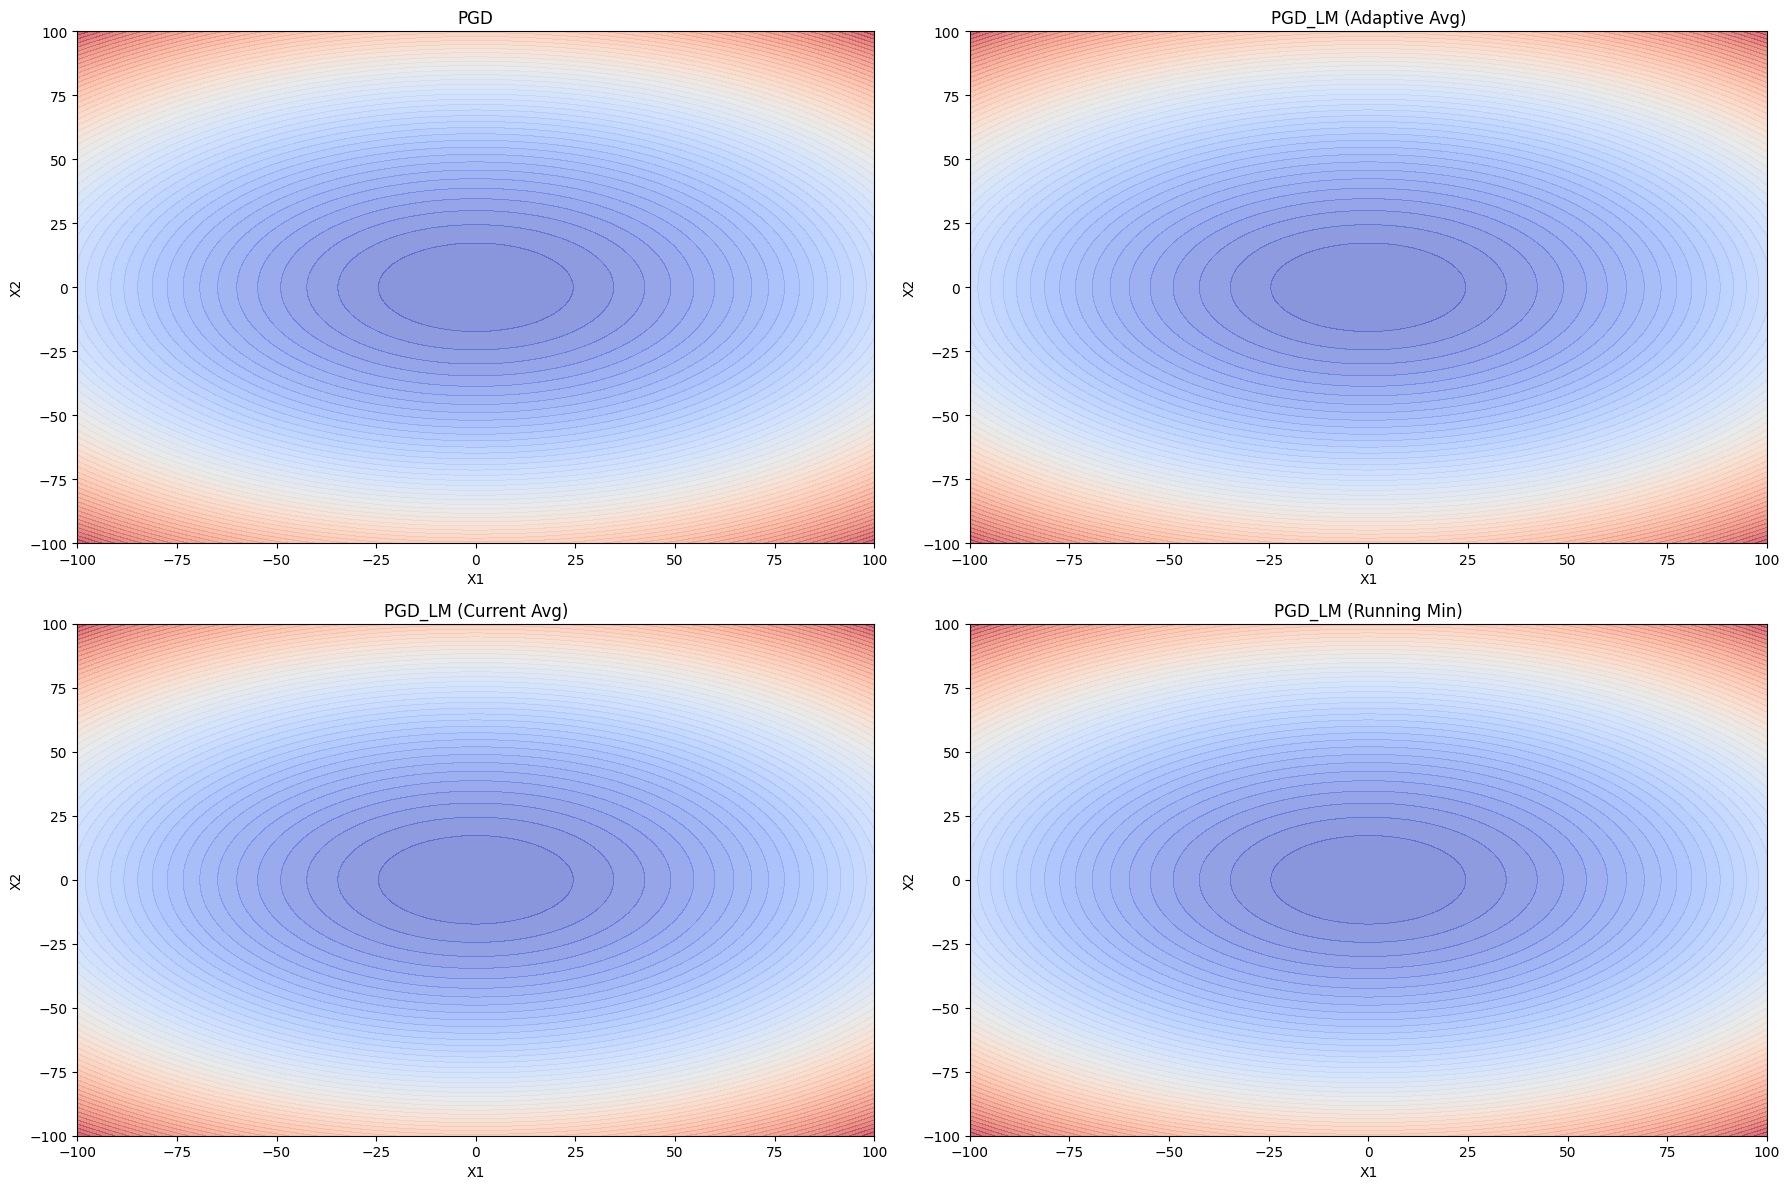

In [30]:
x_range = np.linspace(-100, 100, 100)
y_range = np.linspace(-100, 100, 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_grid = np.array([[bohachevsky(np.array([x, y])) for x, y in zip(X_row, Y_row)] for X_row, Y_row in zip(X_grid, Y_grid)])


trajectory_data = [
    (X_pgd, "PGD"),
    (X_pgdlm_adaptive_avg, "PGD_LM (Adaptive Avg)"),
    (X_pgdlm_avg, "PGD_LM (Current Avg)"),
    (X_pgdlm_running_min, "PGD_LM (Running Min)")
]

m = X_pgd.shape[1]  # number of trajectories
T = X_pgd.shape[2]  # number of time steps

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()  # Flatten to iterate easily

lines_all = []
start_scatter_all = []
current_scatter_all = []

for ax, (X_traj, title) in zip(axes, trajectory_data):
    contour = ax.contourf(
        X_grid, Y_grid, Z_grid, 
        levels=50, 
        cmap='coolwarm', 
        alpha=0.6
    )
    ax.set_title(title)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")

    subplot_lines = []
    subplot_start_scatter = []
    subplot_current_scatter = []

    for i in range(m):
        # Create an empty line
        line_obj, = ax.plot([], [], 'b-', alpha=0.6)
        # Scatter for start position
        start_scat = ax.scatter([], [], color='blue', marker='x')
        # Scatter for the current (moving) position
        current_scat = ax.scatter([], [], color='darkblue', marker='o')

        subplot_lines.append(line_obj)
        subplot_start_scatter.append(start_scat)
        subplot_current_scatter.append(current_scat)

    lines_all.append(subplot_lines)
    start_scatter_all.append(subplot_start_scatter)
    current_scatter_all.append(subplot_current_scatter)

# Create the animation
ani = animation.FuncAnimation(
    fig,         # The figure object 
    update,      # Update function
    frames=T,    # Total number of frames (time steps)
    init_func=init,
    blit=False,  # Turn on if everything can be drawn in one go
    interval=200 # Delay between frames in milliseconds
)

plt.tight_layout()
plt.show()


ani.save("Plots/trajectories_Bohachevsky.mp4", writer='ffmpeg', fps=5)


## Rosenbrock Function

In [31]:
def rosenbrock(x):
    return sum((x[1:]-x[:-1])**2.0 + (1-x[:-1])**2.0)

def grad_rosenbrock(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    grad = np.zeros_like(x)
    grad[1:-1] = 2*(xm - xm_m1) - 2*(1 - xm)
    grad[0] = -2*(x[1] - x[0]) - 2*(1 - x[0])
    grad[-1] = 2*(x[-1] - x[-2])
    return grad

In [32]:
# Parameters
d = 2
m = 10
n_iter = 1000
tau = 10.0 

X_init = np.random.uniform(-10, 10, (d, m))  

alpha_init = 10.0
decay_factor = 0.99
f_mod = lambda x: x**2
epsilon = 1.0

# Run Experiment
X_pgd, G_pgd = PGD(X_init, rosenbrock, grad_rosenbrock, tau, n_iter)
X_pgdlm_adaptive_avg, G_pgdlm_adaptive_avg, _ = PGD_LM(X_init, rosenbrock, grad_rosenbrock, tau, n_iter,
                             alpha_init=alpha_init, decay_factor=decay_factor, 
                             f=f_mod, epsilon=epsilon, c_func = "adaptive avg")
X_pgdlm_avg, G_pgdlm_avg, _ = PGD_LM(X_init, rosenbrock, grad_rosenbrock, tau, n_iter,
                             alpha_init=alpha_init, decay_factor=decay_factor, 
                             f=f_mod, epsilon=epsilon,c_func = "curr avg")
X_pgdlm_running_min, G_pgdlm_running_min, _ = PGD_LM(X_init, rosenbrock, grad_rosenbrock, tau, n_iter,
                             alpha_init=alpha_init, decay_factor=decay_factor, 
                             f=f_mod, epsilon=epsilon,c_func = "running min")

X_sgd, G_sgd = SGD(X_init[:,1], rosenbrock, grad_rosenbrock, 0.08, n_iter)
X_adagrad, G_adagrad = Adagrad(X_init[:,1], rosenbrock, grad_rosenbrock, 0.08, n_iter)



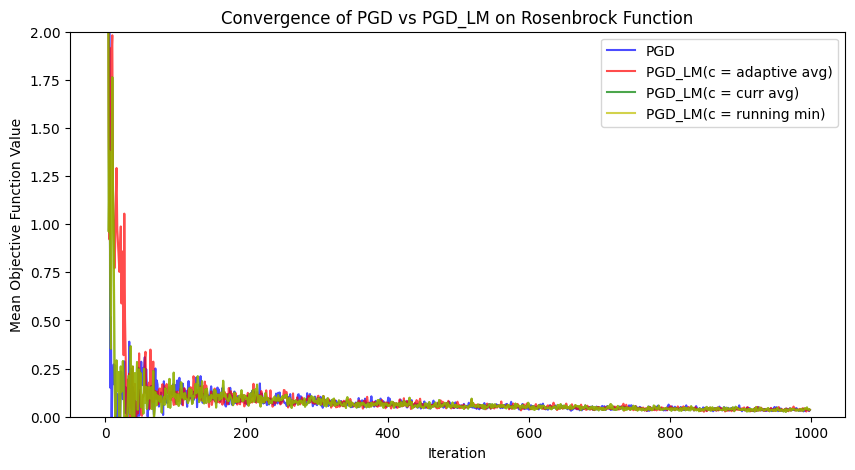

In [36]:
# Plots
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(G_pgd, 'b-', label="PGD", alpha=0.7)
plt.plot(G_pgdlm_adaptive_avg, 'r-', label="PGD_LM(c = adaptive avg)", alpha=0.7)
plt.plot(G_pgdlm_avg, 'g-', label="PGD_LM(c = curr avg)", alpha=0.7)
plt.plot(G_pgdlm_avg, 'y-', label="PGD_LM(c = running min)", alpha=0.7)
plt.xlabel("Iteration")
plt.ylabel("Mean Objective Function Value")
plt.title("Convergence of PGD vs PGD_LM on Rosenbrock Function")
plt.legend()
plt.ylim(0, 2) 
plt.show()

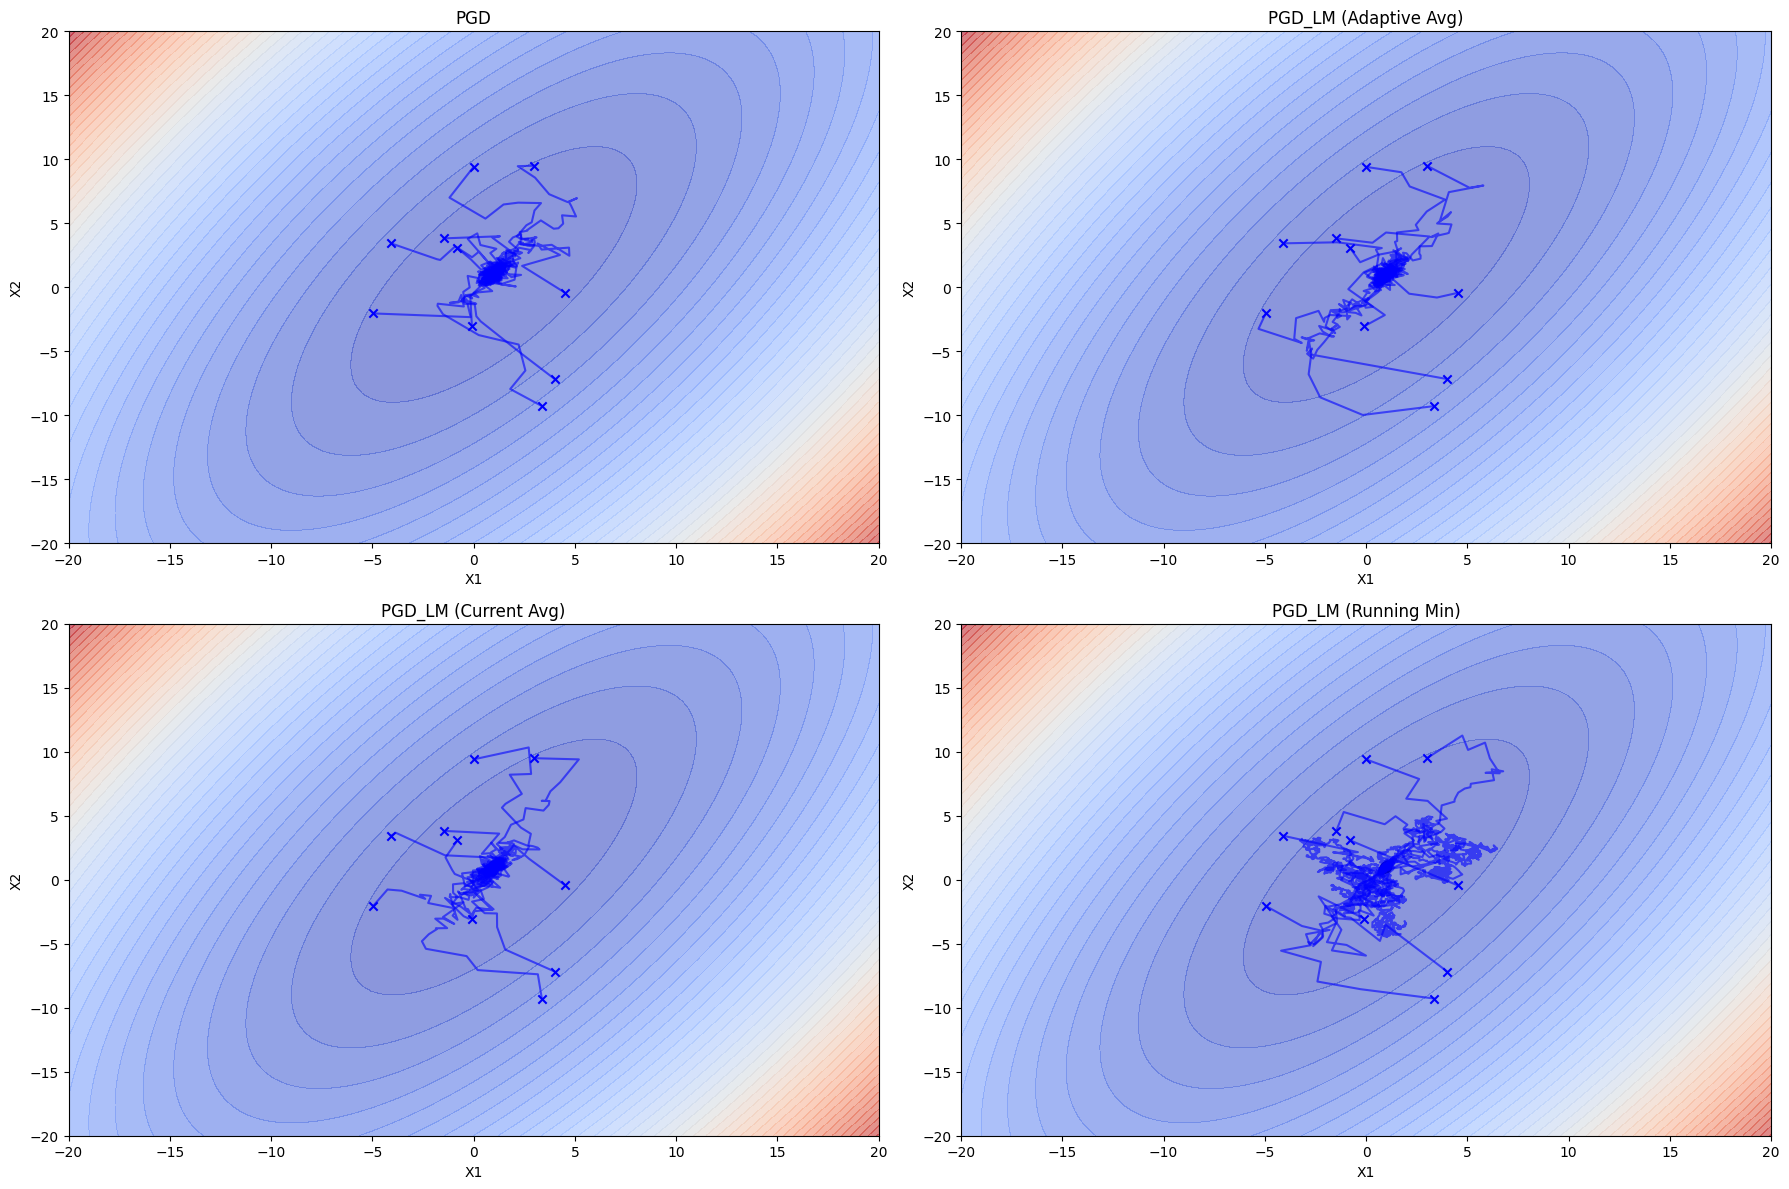

In [35]:
x_range = np.linspace(-20, 20, 100)
y_range = np.linspace(-20, 20, 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_grid = np.array([[rosenbrock(np.array([x, y])) for x, y in zip(X_row, Y_row)] for X_row, Y_row in zip(X_grid, Y_grid)])

# List of trajectory data and titles for the subplots
trajectory_data = [
    (X_pgd, "PGD"),
    (X_pgdlm_adaptive_avg, "PGD_LM (Adaptive Avg)"),
    (X_pgdlm_avg, "PGD_LM (Current Avg)"),
    (X_pgdlm_running_min, "PGD_LM (Running Min)")
]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

for ax, (X_traj, title) in zip(axes.flatten(), trajectory_data):
    ax.contourf(X_grid, Y_grid, Z_grid, levels=50, cmap='coolwarm', alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")

    # Plot trajectories
    for i in range(m):
        ax.plot(X_traj[0, i, :], X_traj[1, i, :], 'b-', alpha=0.6)
        ax.scatter(X_traj[0, i, 0], X_traj[1, i, 0], color='blue', marker='x')  # Start position
        ax.scatter(X_traj[0, i, -1], X_traj[1, i, -1], color='darkblue', marker='o')  # Final position

# Adjust layout and show plot
plt.tight_layout()
plt.show()